# Сервис оценки эмоций пациента по тону голоса на приёме у врача
<hr>


Над проектом работали:
Команда № 2 **'C.D.C'.**

0. Кириленков Кирилл Владимирович

0. Корзун Иван Анатольевич

0. Хван Ок Хи

0. Федеряев Клим Александрович

0. Гайсина Лиана Ильдаровна




<hr>



Для более комфортной работы включите в блокноте GPU и запустите все ячейки с начала:

```
Среда выполнения > Сменить среду выполнения > Аппаратный ускоритель > GPU > Сохранить
---
Runtime > Change runtime type > Hardware accelerator > GPU > Save
```

In [24]:
# Установка дополнительных модулей
%pip install -q mplcyberpunk wave

# Импорт дополнительных модулей
import torch
import matplotlib.pyplot as plt
import mplcyberpunk
import soundfile as sf
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import wave

In [25]:
# @title Загрузите ваш речевой аудиофайл
# @markdown ### Загружайте только аудио файлы в формате .wav или .ogg
# @markdown ### не короче 15 секунд!
# @markdown ########################################################
# @markdown ### Быстро раздобыть файл формата .ogg для тестирования
# @markdown ###  можно с помощью скачивания аудиосообщения из ТГ

from google.colab import files
result = files.upload()
file_name, value = list(result.items())[0]

# Если загрузился файл .ogg, то он будет переконвертирован в .wav

if '.ogg' in file_name:
    data, samplerate = sf.read(file_name)
    file_name = file_name[0:-4] + '.wav'
    sf.write(file_name, data, samplerate)
    print(file_name)


Saving troll.ogg to troll.ogg
troll.wav


In [26]:
# @title Этот фрагмент кода разделяет исходный файл на N частей.
# Количество сегментов
N = 5

def segmentator(N_segments: int, f_name: str):

    with wave.open(f_name, "rb") as infile:
            # get file data
        nchannels = infile.getnchannels()
        sampwidth = infile.getsampwidth()
        framerate = infile.getframerate()
        frames = infile.getnframes()
        duration = frames / float(framerate)
        print(f'Продолжительность загруженного файла: {round(duration, 2)} сек. \n')
        segment = duration / N
        segments = [i * segment for i in range(N + 1)]

        for i in range(len(segments) - 1):

            # set position in wave to start of segment
            infile.setpos(int(segments[i] * framerate))
            # extract data
            data = infile.readframes(int((segments[i + 1] - segments[i]) * framerate))

            # write the extracted data to a new file
            with wave.open(f'{i}_output.wav', 'w') as outfile:
                outfile.setnchannels(nchannels)
                outfile.setsampwidth(sampwidth)
                outfile.setframerate(framerate)
                outfile.setnframes(int(len(data) / sampwidth))
                outfile.writeframes(data)
                print(str(outfile))

segmentator(N, file_name)

Продолжительность загруженного файла: 64.43 сек. 



In [27]:
# Загрузка в предобученной модели

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")
num2emotion = {0: 'neutral', 1: 'angry', 2: 'positive', 3: 'sad', 4: 'other'}

Some weights of the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametri

In [28]:
# Инициализация итогового словаря

result_dict = {}

# Обработка фрагметов загруженного файла в цикле с помощью модели

print('Краткий вывод модели по каждому сегменту \n')

for i in range(N):

    filepath = f'{i}_output.wav'
    waveform, sample_rate = torchaudio.load(filepath, normalize=True)
    transform = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = transform(waveform)

    inputs = feature_extractor(
            waveform,
            sampling_rate=feature_extractor.sampling_rate,
            return_tensors="pt",
            padding=True,
            max_length=16000 * 10,
            truncation=True
        )

    logits = model(inputs['input_values'][0]).logits
    del(inputs)
    del(transform)
    predictions = torch.argmax(logits, dim=1)
    predicted_emotion = num2emotion[predictions.numpy()[0]]
    print(f'segment {i} dominant emotion: ' + predicted_emotion)

    # Инициализация внутреннего словаря
    # и добавление его в итоговый словарь result_dict

    result_dict[filepath] = {}
    for num, emotion in num2emotion.items():
        result_dict[filepath][emotion] = logits[0][num].item()

Краткий вывод модели по каждому сегменту 

segment 0 dominant emotion: angry
segment 1 dominant emotion: neutral
segment 2 dominant emotion: positive
segment 3 dominant emotion: neutral
segment 4 dominant emotion: neutral


In [29]:
# Отформатированный вывод итогового словаря c подробными
# нормированными на 0 значениями
print('Подробный вывод модели по каждому сегменту \n')
for k, v in result_dict.items():
    print(f'{k}: {v}')

Подробный вывод модели по каждому сегменту 

0_output.wav: {'neutral': 1.4757654666900635, 'angry': 2.6411616802215576, 'positive': 1.38972806930542, 'sad': -2.086099863052368, 'other': -3.9621853828430176}
1_output.wav: {'neutral': 3.7846858501434326, 'angry': -0.5959925055503845, 'positive': 2.160025119781494, 'sad': -2.4885165691375732, 'other': -4.461917877197266}
2_output.wav: {'neutral': 3.321500301361084, 'angry': -1.4153249263763428, 'positive': 3.464848041534424, 'sad': -2.816406488418579, 'other': -4.04295539855957}
3_output.wav: {'neutral': 2.798140525817871, 'angry': 0.5955421328544617, 'positive': 1.5682774782180786, 'sad': -1.792826771736145, 'other': -4.350460052490234}
4_output.wav: {'neutral': 3.1054375171661377, 'angry': 0.14991989731788635, 'positive': 1.480706810951233, 'sad': -1.7238013744354248, 'other': -4.339387893676758}


# Обработка результатов и визуализация

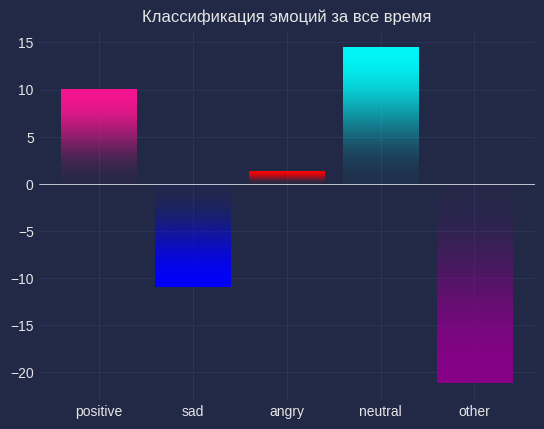

In [30]:
# Классификация эмоций за все время. Суммирует все эмоции на всех фрагментах исходного файла
# Создаем словарь для подсчета эмоций
emotion_counts = {'positive': 0, 'sad': 0, 'angry': 0, 'neutral': 0, 'other': 0}

# Подсчитываем количество каждой эмоции
for res in result_dict.values():
    for emotion, value in res.items():
        if emotion in ['positive']:
            emotion_counts['positive'] += value
        elif emotion in [ 'sad']:
            emotion_counts['sad'] += value
        elif emotion == 'angry':
            emotion_counts['angry'] += value
        elif emotion == 'neutral':
            emotion_counts['neutral'] += value
        elif emotion == 'other':
            emotion_counts['other'] += value

# Создаем списки для графика
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

# Определяем цвета для каждой эмоции
color_mapping = {
    'angry': '#FF0000',
    'positive': '#FF1493',
    'other': '#8B008B',
    'neutral': '#00FFFF',
    'sad': '#0000FF'
}

# Список цветов для графика
colors = [color_mapping[emotion] for emotion in emotions]

# Создаем график
plt.style.use('cyberpunk')
bars = plt.bar(emotions, counts, color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.title('Классификация эмоций за все время')

# Добавляем линии координатной оси x
plt.axhline(0, color='white', linewidth=0.5)

# Отображаем график
plt.show()

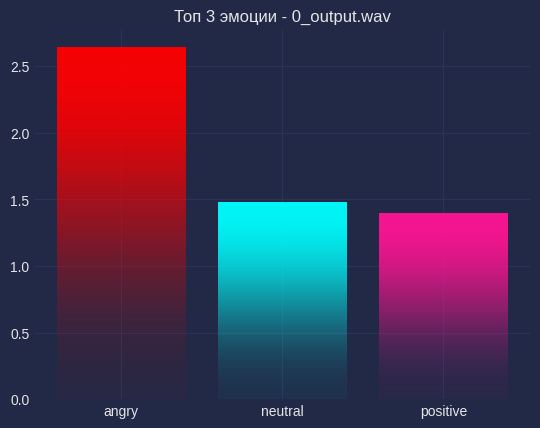

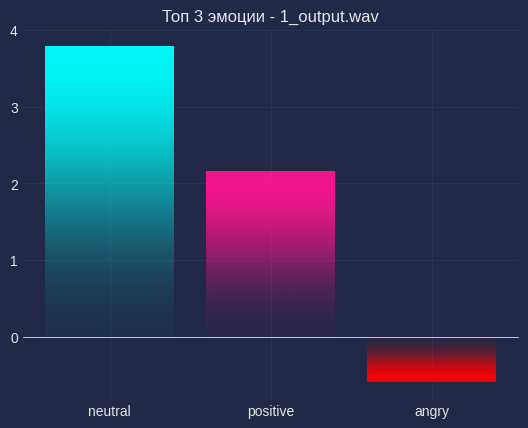

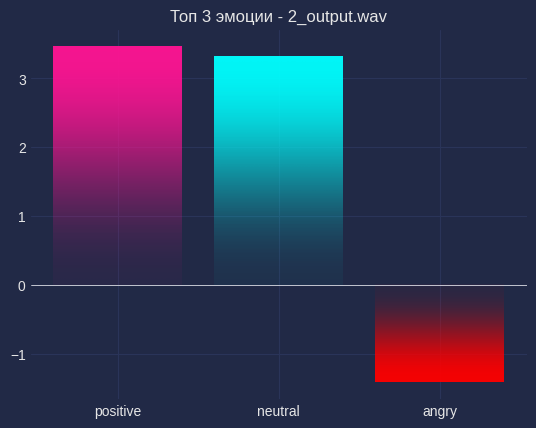

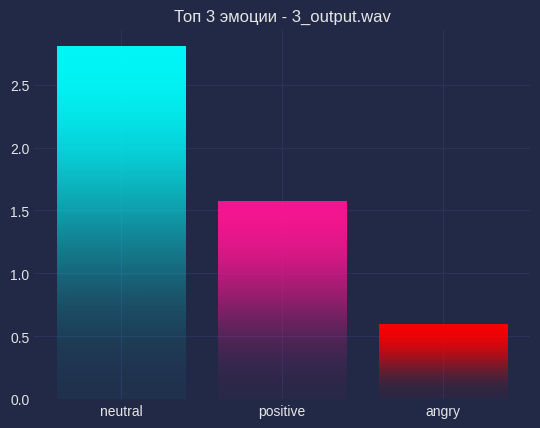

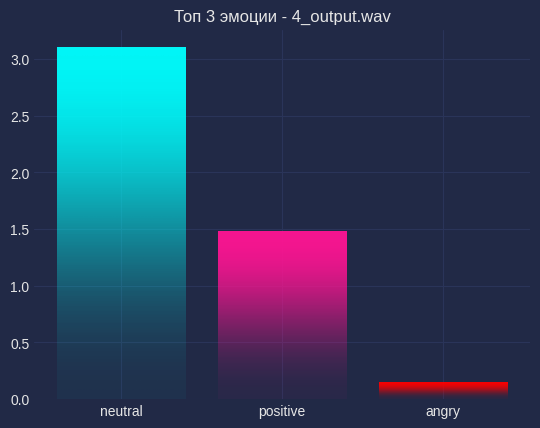

In [31]:
# Отображение гистограммы "Топ-3 Эмоции" для каждого фрагмента записи отдельно

for key, value in result_dict.items():
    # Получаем эмоции и вероятности из словаря результатов
    emotions, probabilities = zip(*value.items())

    # Сортируем эмоции по убыванию вероятностей
    sorted_emotions = [emotion for _, emotion in sorted(zip(probabilities, emotions), reverse=True)]
    sorted_probabilities = sorted(probabilities, reverse=True)

    # Выбираем три наибольших значения эмоций
    top_emotions = sorted_emotions[:3]
    top_probabilities = sorted_probabilities[:3]

    # Построим гистограмму
    # Создаем словарь с соответствием цветов эмоциям
    color_mapping = {
        'angry': '#FF0000',
        'positive': '#FF1493',
        'other': '#8B008B',
        'neutral': '#00FFFF',
        'sad': '#0000FF'
    }

    # Получаем список цветов для каждой эмоции из топ-3
    colors = [color_mapping[emotion] for emotion in top_emotions]

    # Используем стиль 'cyberpunk' для графика
    plt.style.use('cyberpunk')
    bars = plt.bar(range(len(top_emotions)), top_probabilities, color=colors)
    mplcyberpunk.add_bar_gradient(bars=bars)

    # Устанавливаем заголовок графика
    plt.title(f'Топ 3 эмоции - {key}')

    # Устанавливаем подписи осей x
    plt.xticks(range(len(top_emotions)), top_emotions)

    # Добавляем линию координатной оси x
    plt.axhline(0, color='white', linewidth=0.5)

    # Отображаем график
    plt.show()
    print()

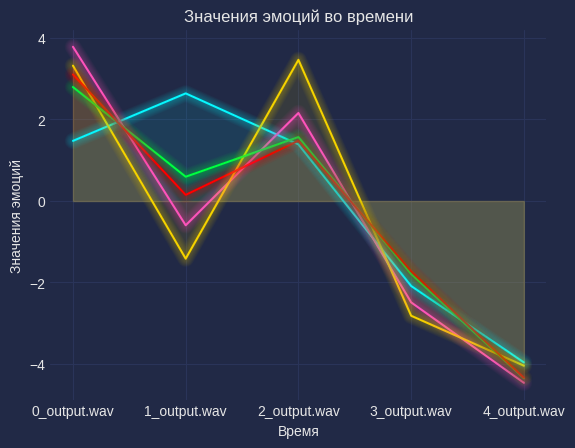

In [32]:
time_values = []  # Список для значений времени
emotion_values = []  # Список для значений эмоций
emotion_keys = []  # Список для ключей эмоций

# Итерация по элементам словаря result_dict
for key, value in result_dict.items():
    emotions, probabilities = zip(*value.items())

    # Добавление значений времени, эмоций и вероятностей в соответствующие списки
    time_values.append(key)
    emotion_keys.append(emotions)
    emotion_values.append(probabilities)

# Построение графика
for i in range(len(time_values)):
    plt.plot(time_values, emotion_values[i], label=emotion_keys[i])

# Настройка осей и заголовка
plt.xlabel('Время')
plt.ylabel('Значения эмоций')
plt.title('Значения эмоций во времени')

mplcyberpunk.add_glow_effects()

# Отображение графика
plt.show()